# ICU Readmissions 

In [24]:
import psycopg2
from psycopg2 import extras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

%matplotlib inline

In [25]:
def cursor_connect(cursor_factory=None):
    """
    Connects to the DB and returns the connection and cursor, ready to use.
    
    Parameters
    ----------
    cursor_factory : psycopg2.extras
    
    Returns
    -------
    (psycopg2.extensions.connection, psycopg2.extensions.cursor)
        A tuple of (psycopg2 connection, psycopg2 cursor).
    """
    #DB connection
    conn = psycopg2.connect(dbname="mimic", user="mimic", host="localhost", port="2345",
                            password="oNuemmLeix9Yex7W")
    if not cursor_factory:
        cur = conn.cursor()
    else:
        cur = conn.cursor(cursor_factory=cursor_factory)
    return conn, cur

def exec_query(query, curs_dict=True):
    """
    Execute query and returns the SQL output.
    
    Parameters
    ----------
    query: string containing SQL SELECT command
    curs_dict: dict cursor factory (output is dict)
    
    Returns
    -------
    rows: list of rows/records (SQL output)
    """
    if curs_dict == True: 
        conn, cur = cursor_connect(psycopg2.extras.DictCursor)
    else:
        conn, cur = cursor_connect()
    cur.execute(query)
    rows = cur.fetchall()
    return rows

## Identify Patients with ICU Readmissions 
Each unique patient (`subject_id`) & their corresponding number of icustays (readmission: n<sub>ICU stay</sub> > 1).

In [26]:
# query
q_icupat="""SELECT * FROM
    (SELECT subject_id, COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id) AS sub_q
WHERE n_icustays > 1;"""

# Query output
icu_pat = exec_query(q_icupat, False)
df_icu_pat = pd.DataFrame(icu_pat, columns=['subjectid', 'n_icustays'])
df_icu_pat

,subjectid,n_icustays
0,7,2
1,17,2
2,21,2
3,23,2
4,34,2
5,36,3
6,41,2
7,61,2
8,67,2
9,68,3


# Care Units
  1. Mobile Intensive Care Unit (`MICU`)
  2. Cardiac Surgery Recovery Unit (`CSRU`)
  3. Surgical Intensive Care Unit (`SICU`)
  4. Neonatal Intensive Care Unit (`NICU`)
  5. Cardiac Care Unit (`CCU`)
  6. Trauma Surgical Intensive Care Unit (`TSICU`)

**Note**: Exclusion of `NICU` (minors)

## Distribution of First & Last Care Units
Frequency of a care unit's use by ICU readmitted patients for admission and discharge (end-points).

In [27]:
# query
q_cu = """SELECT subject_id, first_careunit, last_careunit
    FROM icustays;"""

# Query output
cu = exec_query(q_cu, False)
df_cu = pd.DataFrame(cu, 
                           columns=['subjectid', 'first_cu', 'last_cu'])

# filter for readmitted ICU patients
filter_preadm = list(df_icu_pat.subjectid)
df_cu_readm = df_cu[df_cu.subjectid.isin(filter_preadm)]

# map number of icustays to each patient
num_icur_map = df_icu_pat.set_index('subjectid').to_dict()['n_icustays']
num_icur = pd.Series(df_cu_readm.subjectid.map(num_icur_map), name='n_icustays')
df_cu_readm = pd.concat([df_cu_readm, num_icur], axis=1)

# Number of ICU readmitted patients per CU
fcu_ct = df_cu_readm['subjectid'].groupby(df_cu_readm['first_cu']).agg('count')
lcu_ct = df_cu_readm['subjectid'].groupby(df_cu_readm['last_cu']).agg('count')
fcu_ct.name = 'fcu_n_icustays'
lcu_ct.name = 'lcu_n_icustays'

# Extract percentages
fcur_perc = (fcu_ct / fcu_ct.sum() * 100).round(decimals=2)
fcur_perc.name = 'fcu_perc'
lcur_perc = (lcu_ct / lcu_ct.sum() * 100).round(decimals=2)
lcur_perc.name = 'lcu_perc'

df_cu_readm_grp = pd.concat([fcu_ct, lcu_ct, fcur_perc, lcur_perc], axis=1)
df_cu_readm_grp.sort_values('fcu_perc', ascending=False)

,fcu_n_icustays,lcu_n_icustays,fcu_perc,lcu_perc
MICU,10917,11052,45.85,46.42
SICU,3962,4080,16.64,17.13
CCU,3449,3385,14.48,14.22
CSRU,3175,3132,13.33,13.15
TSICU,1854,1708,7.79,7.17
NICU,454,454,1.91,1.91


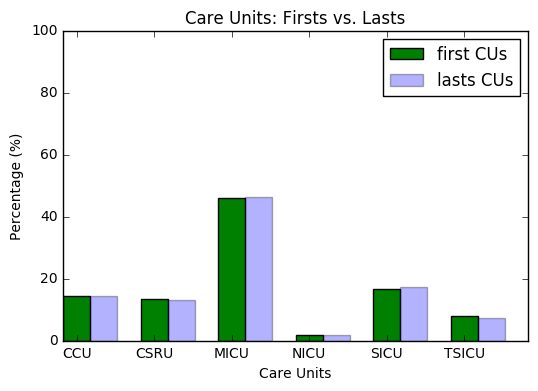

In [28]:
fig, ax = plt.subplots()
index = np.arange(6)
bar_width=0.35

rects1 = plt.bar(index, df_cu_readm_grp.fcu_perc, bar_width,
        alpha=1.0, color='g', label='first CUs')
rects2 = plt.bar(index + bar_width, df_cu_readm_grp.lcu_perc, bar_width,
        alpha=0.3, color='b', label='lasts CUs')
plt.xlabel('Care Units')
plt.ylabel('Percentage (%)')
plt.ylim([0, 100])
plt.xticks(index + bar_width/2, df_cu_readm_grp.index)
plt.legend()
plt.title('Care Units: Firsts vs. Lasts')
plt.show()

**Results**:
  * Similar distributions amongsts care units for both admission (`first_careunits`) and discharge (`last_careunits`).
  * **Mobile Intensive Care Unit (`MICU`)** account for majority of admissions & discharge of readmitted ICU patients (~45-46%).

# Care Unit Traversals

#### Unique Combinations
n<sub>unique combo</sub> = `(n!) / (k! (n - k)!)`
  * **n**: number of sample points in a set
  * **k**: number of sample points in each combination

n<sub>ICU combo</sub> = (5!) / (2! (5-2)!) = **10 possible unique ICU traversal pairs**

#### Important Notes:
  * Care Units are defined based off the `WARDID` being associated with an ICU cost center. Thus, each ICU (`PREV_CAREUNIT` and `CURR_CAREUNIT`) is associated with a `WARDID`, but *not every* `WARDID` is an ICU.
  * Definition of a `WARDID` is not consistent. ICUs in the Beth Israel Deaconess Hospital moved throughout the year.

## Admission (`First`) - Discharge (`Last`) CU Traversal
`first_cu - last_cu`

Transfer pairs of admission and discharge ICUs for readmitted ICU patients.

### Count & Overall Probability of End-Point Transfer Pairs
**Overall Probability**: The probability/percentage of a transfer pair in relation to overall possibilities.

In [29]:
df_cu_readm = df_cu_readm[df_cu_readm['first_cu'] != 'NWARD']
df_cu_readm = df_cu_readm[df_cu_readm['first_cu'] != 'NICU']
df_cu_readm = df_cu_readm[df_cu_readm['last_cu'] != 'NWARD']
df_cu_readm = df_cu_readm[df_cu_readm['last_cu'] != 'NICU']
df_cu_readm['trans']=df_cu_readm.first_cu+'-'+df_cu_readm.last_cu
df_cu_readm

,subjectid,first_cu,last_cu,n_icustays,trans
0,109,MICU,MICU,38,MICU-MICU
1,109,MICU,MICU,38,MICU-MICU
2,109,MICU,SICU,38,MICU-SICU
3,109,SICU,MICU,38,SICU-MICU
4,109,MICU,MICU,38,MICU-MICU
5,109,MICU,MICU,38,MICU-MICU
6,109,MICU,MICU,38,MICU-MICU
7,109,SICU,SICU,38,SICU-SICU
8,109,SICU,SICU,38,SICU-SICU
9,109,MICU,MICU,38,MICU-MICU


In [42]:
df_readm_trans=df_cu_readm.groupby(['trans'])
df_readm_trans.size().sort_values(ascending=False)
df_readm_trans = df_readm_trans.size().to_frame(name='n_trans')
df_readm_trans = df_readm_trans.reset_index()
df_cu_trans_endpt = pd.Series(df_readm_trans.n_trans / df_readm_trans.n_trans.sum(), 
                              name='perc_trans')
df_readm_trans = pd.concat([df_readm_trans, df_cu_trans_endpt], axis=1)
df_readm_trans.sort_values('perc_trans', ascending=False)

,trans,n_trans,perc_trans
12,MICU-MICU,10411,0.445734
18,SICU-SICU,3674,0.157298
0,CCU-CCU,3013,0.128998
6,CSRU-CSRU,2890,0.123732
24,TSICU-TSICU,1580,0.067646
2,CCU-MICU,228,0.009762
13,MICU-SICU,221,0.009462
17,SICU-MICU,183,0.007835
10,MICU-CCU,174,0.007450
1,CCU-CSRU,154,0.006593


**Results**: Majority of first-last care unit transfers occur within the same CU.

Top 5:  

|Transfer Pair| Count | %|
|:----|:---:|:--:|
|`MICU-MICU`|10411|44.6%|
|`SICU-SICU`|3574|15.7%|
|`CCU-CCU`|3013|12.9%|
|`CSRU-CSRU`|2890|12.4%|
|`TSICU-TSICU`|1580|6.8%|


### Probability of `Admission` CU given `Discharge`
Probability of patients deriving from a particular `first CU` for a given `last CU`.

Note: Read by columns (column sum = 1.0)

In [44]:
pd.crosstab(df_cu_readm.first_cu, 
            df_cu_readm.last_cu)/pd.crosstab(df_cu_readm.first_cu, 
                                             df_cu_readm.last_cu).sum()

last_cu,CCU,CSRU,MICU,SICU,TSICU
first_cu,,,,,
CCU,0.890103,0.049170,0.020630,0.010294,0.007026
CSRU,0.036928,0.922733,0.008415,0.012500,0.009368
MICU,0.051403,0.015326,0.942001,0.054167,0.036885
SICU,0.012408,0.008301,0.016558,0.900490,0.021663
TSICU,0.009158,0.004470,0.012396,0.022549,0.925059


**Results**:
  * Patients are most likely to be *discharged* from the same care unit type that they were *admitted* into (~90% probability). Thus, suggesting that most patients likely have 1 ICU stay with no transfers to another care unit.

# Multiple Traversals
Explore full-scope of transfers between wards, *inclusive of admission, transfer, and discharge events*.

In [ ]:
q_mult= """SELECT subject_id, hadm_id, icustay_id, eventtype,
prev_careunit, curr_careunit, prev_wardid, curr_wardid, intime, outtime, los
FROM transfers;"""
mult_trav = exec_query(q_mult, False)
mult_col = ['subjectid', 'hadmid', 'icustayid', 'eventtype', 'prev_cu', 'curr_cu', 
       'prev_wardid', 'curr_wardid', 'intime', 'outtime', 'los']
df_mult = pd.DataFrame(mult_trav, columns = mult_col)
df_mult.replace(to_replace='', value=np.nan, inplace=True, regex=True)

# filter for ICU patients with readmission
df_mult_readm = df_mult[df_mult.subjectid.isin(filter_preadm)]

# filter for exclusion of neonate patients
df_mult_readm = df_mult_readm[df_mult_readm['prev_cu'] != 'NWARD']
df_mult_readm = df_mult_readm[df_mult_readm['prev_cu'] != 'NICU']
df_mult_readm = df_mult_readm[df_mult_readm['curr_cu'] != 'NWARD']
df_mult_readm = df_mult_readm[df_mult_readm['curr_cu'] != 'NICU']
df_mult_readm.sort_values('subjectid')

## Traversals between *All* Wards
Grouped Data by `subject_id` and `hadm_id` to obtain the number of traversals between **wards** (not exclusive to just ICU wards) for each hospital admission (`hadm`) of the patients.

### Count of Ward Traversals per Hospital Admission
Total transfers between wards for each Hospital Admission

In [ ]:
df_mult_readm_grp = df_mult_readm.groupby(['subjectid', 'hadmid']).size()
df_mult_readm_grp

In [ ]:
df_mult_readm_grp = df_mult_readm.groupby(['subjectid', 'hadmid']).size()
df_mult_readm_grp = df_mult_readm_grp.to_frame(name='n_trav').reset_index()
# join DF  on subjectid to add n_readm col
df_mult_readm_grp1 = pd.merge(df_mult_readm_grp, df_icu_pat, on='subjectid', 
                        how='left')

# # Convert n_icustays col to n_readm col
df_mult_readm_grp1.rename(columns={'n_icustays': 'n_readm'}, inplace=True)
df_mult_readm_grp1.n_readm = df_mult_readm_grp1.n_readm - 1 # transformation

df_mult_readm_grp1

#### Summary Statistics

In [ ]:
df_mult_readm_grp1.describe()

In [ ]:
print "Average Ward Transfers %.2f" % df_mult_readm_grp1.n_trav.mean()
print "Standard Deviation Ward Transfers %.2f" % df_mult_readm_grp1.n_trav.std()
print "Median Ward Transfers %.2f" % df_mult_readm_grp1.n_trav.median()
print "Max Ward Transfers %.2f" % df_mult_readm_grp1.n_trav.max()

#### Distribution of Ward Transfers

In [ ]:
plt.hist(df_mult_readm_grp1.n_trav, bins=25)
plt.xlabel('Number of Transfers (n)')
plt.ylabel('Frequency')
plt.title('Histogram: Number of Ward Traversals')
plt.show()

The number of ward traversals in a hospital admission has a *right-skewed* distribution, where the right tail is longer. Thus indicating that the mean (4.8 transfers) > median (4.00 transfers).

#### Correlation: n<sub>Ward Transfers</sub> vs. n<sub>ICU Readmissions</sub>

In [ ]:
plt.scatter(df_mult_readm_grp1.n_trav, df_mult_readm_grp1.n_readm)
plt.xlabel('Number of Ward Transfers (n)')
plt.ylabel('Number of ICU Readmissions (n)')
plt.xlim([0, 30])
plt.ylim([-1, 45])
plt.title('Scatter Plot: Ward Traversals vs. ICU Readmissions')
plt.show()

In [ ]:
pear_ward_trav = df_mult_readm_grp1.corr(method='pearson').loc['n_trav', 'n_readm']
spear_ward_trav = df_mult_readm_grp1.corr(method='spearman').loc['n_trav', 'n_readm']
print "Pearson Correlation Coefficient %.3f" % pear_ward_trav
print "Spearman Correlation Coefficient %.3f" % spear_ward_trav

The two variables (`n`<sub>all ward traversals</sub> and `n`<sub>ICU readmissions</sub>) have a weak correlation as indicated by the low `Pearson` (linear relationship) and `Spearman` (rank-order/monotonic) coefficients.

### Ward Transfer Pairs

#### Count of Pairs
Frequency of ward transfer pairs.

In [ ]:
df_mult_readm_alltrans = df_mult_readm.copy()
df_mult_readm_alltrans.prev_cu.fillna('nonicu', inplace=True)
df_mult_readm_alltrans.curr_cu.fillna('nonicu', inplace=True)
df_mult_readm_alltrans['trans'] = df_mult_readm_alltrans.prev_cu+'-'+df_mult_readm_alltrans.curr_cu
df_mult_readm_alltrans

df_readm_alltrans=df_mult_readm_alltrans.groupby(['trans'])
df_readm_alltrans.size().sort_values(ascending=False)

#### Probability of Ward Transfer Pairs

In [ ]:
pd.crosstab(
    df_mult_readm_alltrans.prev_cu, 
    df_mult_readm_alltrans.curr_cu)/(pd.crosstab(
    df_mult_readm_alltrans.prev_cu, 
    df_mult_readm_alltrans.curr_cu).sum())

## Traversals to *only* ICU Wards
Transfers between only ICU wards, which are considered an ICU stay (`icustay_id`).

In [ ]:
df_mult_readm_icu = df_mult_readm[df_mult_readm.icustayid.notnull()==True]
df_mult_readm_icu

### Probability of Transfers to an ICU Ward (`icustay_id`)
  * Counts all ICU stays of a hospital admission, inclusive of admission and transfers.  

**Note**: Cross-Tab is discounting the transfers between ICU and non-ICU wards due to nan values. Thus, `nan` values were "filled in" and denoted by "non-icu" string.

In [ ]:
# fill nan
mult_icutrav_prev = df_mult_readm_icu.prev_cu.fillna('nonicu')
mult_icutrav_curr = df_mult_readm_icu.curr_cu.fillna('nonicu')
pd.crosstab(mult_icutrav_prev, 
            mult_icutrav_curr)/pd.crosstab(mult_icutrav_prev,
                                           mult_icutrav_curr).sum()

**Results**:
  * Majority of the ICU stays resulted from patients being transferred from a `non-ICU` ward, with the *exception of NICU*.
    * CCU: 84.21%
    * CSRU: 71.68%
    * MICU: 84.60%
    * SICU: 84.02%
    * TSICU: 82.73%
  

### Count of ICU Transfers within each Hospital Admission
Total icustays within each admission (inclusive of same and different icustays)

In [ ]:
df_mult_readm_hadm = df_mult_readm_icu.groupby(['subjectid', 'hadmid']).size().to_frame('n_icutrav').reset_index()

# join DF  on subjectid to add n_readm col
df_mult_readm_hadm1 = pd.merge(df_mult_readm_hadm, df_icu_pat, on='subjectid', 
                        how='left')

# # Convert n_icustays col to n_readm col
df_mult_readm_hadm1.rename(columns={'n_icustays': 'n_readm'}, inplace=True)
df_mult_readm_hadm1.n_readm = df_mult_readm_hadm1.n_readm - 1 # transformation

df_mult_readm_hadm1

#### Summary Statistics

In [ ]:
print "Average ICU Ward Traversals %.2f" % df_mult_readm_hadm1.n_icutrav.mean()
print "Standard Deviation ICU Ward Traversals %.2f" % df_mult_readm_hadm1.n_icutrav.std()
print "Median ICU Ward Traversals %.2f" % df_mult_readm_hadm1.n_icutrav.median()
print "Max ICU Ward Traversal %.2f" % df_mult_readm_hadm1.n_icutrav.max()

df_mult_readm_hadm1.describe()

#### Distribution of ICU Ward Transfers per HADM

In [ ]:
plt.hist(df_mult_readm_hadm1.n_icutrav, bins=10)
plt.xlabel('Number of Transfers (n)')
plt.ylabel('Frequency')
plt.title('Histogram: Number of ICU Ward Traversals')
plt.show()

The number of ICU ward traversals in a hospital admission has a *right-skewed* distribution, where the right tail is longer. Thus indicating that the mean (1.55 ICU transfers) > median (1.00 ICU transfers).

#### Correlation: ICU Ward Transfers (per HADM) vs. ICU Readmissions

In [ ]:
plt.scatter(df_mult_readm_hadm1.n_icutrav, df_mult_readm_hadm1.n_readm)
plt.xlabel('Number of ICU Ward Transfers (n)')
plt.ylabel('Number of ICU Readmissions (n)')
# plt.xlim([0, 12])
plt.ylim([-1, 45])
plt.title('Scatter Plot: ICU Ward Traversals (HADM) vs. ICU Readmissions')
plt.show()

In [ ]:
pear_icu_trav = df_mult_readm_hadm1.corr(method='pearson').loc['n_icutrav', 'n_readm']
spear_icu_trav = df_mult_readm_hadm1.corr(method='spearman').loc['n_icutrav', 'n_readm']
print "Pearson Correlation Coefficient %.3f" % pear_icu_trav
print "Spearman Correlation Coefficient %.3f" % spear_icu_trav

The two variables (`n_icutrav` and `n_readm`) have a weak correlation as indicated by the low `Pearson` (linear relationship) and `Spearman` (rank-order/monotonic) coefficients.

### Count ICU Transfers within each ICU Stay
Count multiple transfers within the SAME icustay (< 24 hours)

In [ ]:
df_mult_readm_icustay = df_mult_readm_icu.groupby(['subjectid', 'hadmid', 'icustayid']).size().to_frame('n_mult_icutrav').reset_index()

# join DF  on subjectid to add n_readm col
df_mult_readm_icustay1 = pd.merge(df_mult_readm_icustay, df_icu_pat, on='subjectid', 
                        how='left')

# # Convert n_icustays col to n_readm col
df_mult_readm_icustay1.rename(columns={'n_icustays': 'n_readm'}, inplace=True)
df_mult_readm_icustay1.n_readm = df_mult_readm_icustay1.n_readm - 1 # transformation

df_mult_readm_icustay1

#### Summary Statistics

In [ ]:
print "Average ICU Ward Traversals %.2f" % df_mult_readm_icustay1.n_mult_icutrav.mean()
print "Standard Deviation ICU Ward Traversals %.2f" % df_mult_readm_icustay1.n_mult_icutrav.std()
print "Median ICU Ward Traversals %.2f" % df_mult_readm_icustay1.n_mult_icutrav.median()
print "Max ICU Ward Traversal %.2f" % df_mult_readm_icustay1.n_mult_icutrav.max()

df_mult_readm_icustay1.describe()

In [ ]:
plt.hist(df_mult_readm_icustay1.n_mult_icutrav, bins=11)
plt.xlabel('Number of ICU Transfers (n)')
plt.ylabel('Frequency')
plt.title('Histogram: Number of ICU Ward Traversals (ICU Stay)')
plt.show()

The number of ICU ward traversals in an ICU stay has a *right-skewed* distribution, where the right tail is longer. Thus indicating that the mean (1.31 ICU transfers) > median (1.00 ICU transfers).

#### Correlation: ICU Ward Transfers (per ICU Stay) vs. ICU Readmissions 

In [ ]:
plt.scatter(df_mult_readm_icustay1.n_mult_icutrav, df_mult_readm_icustay1.n_readm)
plt.xlabel('Number of ICU Ward Transfers (n)')
plt.ylabel('Number of ICU Readmissions (n)')
# plt.xlim([0, 12])
plt.ylim([-1, 45])
plt.title('Scatter Plot: ICU Ward Traversals (ICU Stay) vs. ICU Readmissions')
plt.show()

In [ ]:
pear_icustay_trav = df_mult_readm_icustay1.corr(method='pearson').loc['n_mult_icutrav', 'n_readm']
spear_icustay_trav = df_mult_readm_icustay1.corr(method='spearman').loc['n_mult_icutrav', 'n_readm']
print "Pearson Correlation Coefficient %.3f" % pear_icustay_trav
print "Spearman Correlation Coefficient %.3f" % spear_icustay_trav

The two variables (`n_icutrav` and `n_readm`) have a weak correlation as indicated by the low `Pearson` (linear relationship) and `Spearman` (rank-order/monotonic) coefficients. Thus, there appears to be no correlation between the number of ICU ward transfers **within an ICU stay** and the number of ICU readmissions.

## Frequency of Transfer Per ICU Ward

In [ ]:
df_test = df_mult_readm_icu.copy()
df_test.prev_cu.fillna('NON-ICU', inplace=True)
df_test.curr_cu.fillna('NON-ICU', inplace=True)
df_t = pd.Series(df_test.prev_cu+'-'+df_test.curr_cu, name='trans')
df_test = pd.concat([df_test, df_t], axis=1)

df_transfer = df_test[df_test.eventtype == 'transfer']
df_admit = df_test[df_test.eventtype == 'admit']

df_transfer.groupby(['prev_cu', 'curr_cu', 'eventtype']).size()

# Time of Transfer (`Day` vs. `Night`)
Explore the relationship between the time (`day` or `night`) and ICU readmissions.

In [ ]:
def day_night(datetime):
    if pd.isnull(datetime):
        time = np.nan
    else:
        hour = np.timedelta64(np.datetime64(datetime, 'h') - (np.datetime64(datetime, 'D')), 'h')
        if hour.astype(np.int64) >=6 and hour.astype(np.int64) <=18:
            time = 'day'
        else:
            time = 'night'
    return time

In [ ]:
df_intime=pd.Series(df_mult_readm['intime'].apply(day_night), name='in_t')
df_outtime=pd.Series(df_mult_readm['outtime'].apply(day_night), name='out_t')
df_readm_time = pd.concat([df_mult_readm, df_intime, df_outtime], axis=1)
df_readm_time

## Transfer Time: `in`

In [ ]:
df_readm_inday = df_readm_time[df_readm_time.in_t == 'day']
df_readm_innight = df_readm_time[df_readm_time.in_t == 'night']

# GroupBy to Obtain number of transfers
df_readm_inday_grp = df_readm_inday.groupby(['subjectid', 'hadmid']).size().to_frame(name='n_trav').reset_index()
df_readm_innight_grp = df_readm_innight.groupby(['subjectid', 'hadmid']).size().to_frame(name='n_trav').reset_index()

# join DF  on subjectid to add n_readm col
df_readm_inday_grp1 = pd.merge(df_readm_inday_grp, df_icu_pat, 
                                  on='subjectid', how='left')
df_readm_innight_grp1 = pd.merge(df_readm_innight_grp, df_icu_pat, 
                                  on='subjectid', how='left')

# Convert n_icustays col to n_readm col
df_readm_inday_grp1.rename(columns={'n_icustays': 'n_readm'}, inplace=True)
df_readm_innight_grp1.rename(columns={'n_icustays': 'n_readm'}, inplace=True)

df_readm_inday_grp1.n_readm = df_readm_inday_grp1.n_readm - 1 # transformation
df_readm_innight_grp1.n_readm = df_readm_innight_grp1.n_readm - 1 # transformation

df_readm_inday_grp1.shape, df_readm_innight_grp1.shape

### Summary Statistics

In [ ]:
print "Transfer In - Day:"
print df_readm_inday_grp1.describe()
print "\n Transfer In - Night:"
print df_readm_innight_grp1.describe()

In [ ]:
print "Ward Transfer Stat \t Day \t Night"
print "Average \t\t %.2f \t %.2f" % (df_readm_inday_grp1.n_trav.mean(), df_readm_innight_grp1.n_trav.mean())
print "StD \t\t\t %.2f \t %.2f" % (df_readm_inday_grp1.n_trav.std(), df_readm_innight_grp1.n_trav.std())
print "Median \t\t\t %.2f \t %.2f" % (df_readm_inday_grp1.n_trav.median(), df_readm_innight_grp1.n_trav.median())
print "Max \t\t\t %.2f \t %.2f" % (df_readm_inday_grp1.n_trav.max(), df_readm_innight_grp1.n_trav.max())

### Distribution

In [ ]:
fig=plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(df_readm_inday_grp1.n_trav, bins=11)
plt.xlabel('Number of Transfers (n)')
plt.ylabel('Frequency')
plt.title('Transfer In-Time: Day')

plt.subplot(1,2,2)
plt.hist(df_readm_innight_grp1.n_trav, bins=11)
plt.xlabel('Number of Transfers (n)')
plt.ylabel('Frequency')
plt.title('Transfer In-Time: Night')
plt.suptitle('Histogram: Number of Ward Traversals')

plt.show()

### Correlation

In [ ]:
fig=plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(df_readm_inday_grp1.n_trav, df_readm_inday_grp1.n_readm)
plt.xlabel('Number of Ward Transfers (n)')
plt.ylabel('Number of ICU Readmissions (n)')
plt.title('Day')

plt.subplot(1,2,2)
plt.scatter(df_readm_innight_grp1.n_trav, df_readm_innight_grp1.n_readm)
plt.xlabel('Number of Ward Transfers (n)')
plt.ylabel('Number of ICU Readmissions (n)')
plt.title('Night')
plt.suptitle('Scatter Plot: Ward Traversals vs. ICU Readmissions')
plt.show()

In [ ]:
pear_all_inday = df_readm_inday_grp1.corr(method='pearson').loc['n_trav', 'n_readm']
spear_all_inday = df_readm_inday_grp1.corr(method='spearman').loc['n_trav', 'n_readm']

pear_all_innight = df_readm_innight_grp1.corr(method='pearson').loc['n_trav', 'n_readm']
spear_all_innight = df_readm_innight_grp1.corr(method='spearman').loc['n_trav', 'n_readm']

print "Correlation Coef \t Day \t\t Night"
print "Pearson \t\t %.3f \t %.3f" % (pear_all_inday, pear_all_innight)
print "Spearman \t\t %.3f \t %.3f" % (spear_all_inday, spear_all_innight)

# Issues

### 1) Permutations of Complete Transfer Sequence
Issues:
  * Computationally expensive
    * long run-time
    * not enough memory

In [ ]:
# cu_list = list(df_mult_readm_icu.prev_cu.value_counts().index)
# list(itertools.permutations(cu_list))

In [ ]:
# d_test = dict()
# for index, row in df_test.sort_values('intime').iterrows(): #sort by time?
#     if row.eventtype == 'admit':
#         d_test[row.hadmid] = [row.curr_cu]
#     if row.eventtype == 'transfer':
#         d_test[row.hadmid] = d_test.get(row.hadmid) + [row.curr_cu]
#     if row.eventtype == 'discharge':
#         d_test[row.hadmid] = d_test.get(row.hadmid) + [row.curr_cu]
#     print d_test